### 予測分布を最尤推定とベイズ推定による実装を行う。

**■検証材料**

データの生成は$sin(x)$からガウス分布に従って生成されているとする。
生成された、データ$x$とそれに対応する$t$を使用して、多項式を使用して当てはめたとする。
tは平均が多項式の値に等しく、精度が$\beta$のガウス分布に従うとする。
この分布を使用して、ベイズ推定、最尤推定の両者での訓練データを入力した後の予測分布についてみていく。

まず、必要なモジュールと定義を行う。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

BAYES = 1 #ベイズ推定
MLE = 0   #最尤推定

次に多項式モデルを生成するクラスを作成する。
多項式としては、以下の簡単な多項式とする。
$y(x) = x^1+x^2+・・・x^M$

In [3]:
class Polynomial:
    """
    本クラスは簡単な多項式を生成するクラス。
    多項式としては、1+x^1+x^2・・・x^(D-1) の多項式を提供します。（Dは設定した次元数）
    使用方法
    クラス生成時に次元数を引数に与えるだけで、関数取得時に設定した次元数の多項式を生成します。
    取得する時のメソッドはgetFunction()です。
    引数として、ベクトルもしくは、1つのパラメータを入力する必要があります。
    """
    def __init__(self, diag):
        self.diag = diag
    def getFunction(self, x):
        func = np.array([x**i for i in range(self.diag)])
        return func.T

次に予測分布を算出するクラスを作成する。
予測分布を算出するクラスでは、最尤推定での予測分布モデルを算出するか、ベイズ推定で予測分布モデルを算出するかを選ぶ事ができる。

ここで、ベイズ推定を使用する際に、事後分布を使用して予測分布を算出するが、この事後分布の算出過程を確認する。
前提としては、事前分布として$p(\boldsymbol{w}|\alpha) = N(\boldsymbol{w}|\boldsymbol{0},\alpha^{-1}I)$を用いる。
また、尤度関数は$p(\boldsymbol{t}|\boldsymbol{x}, \boldsymbol{w}, \beta) = \prod_{n}^{N} N(t_n|y(\boldsymbol{w},x_n), \beta^{-1})$であるので、
事後分布は以下の式で算出できる。

$p(\boldsymbol{w}|\boldsymbol{x},\boldsymbol{t},\alpha, \beta) = p(\boldsymbol{t}|\boldsymbol{x}, \boldsymbol{w}, \beta)p(\boldsymbol{w}|\alpha)$

事前分布と尤度関数がガウス分布なので、事後分布もガウス分布となる。
ここで、一般の多変量ガウス分布の指数部分に着目する。

$-\frac{\boldsymbol{1}}{2}(\boldsymbol{\mu}-\boldsymbol{w})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu}-\boldsymbol{w})$

式を展開し、整理すると以下の式となる。

$-\frac{\boldsymbol{1}}{2}(\boldsymbol{\mu}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu} - 2\boldsymbol{w}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu} + \boldsymbol{w}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{w})$

ガウス分布は制御パラメータである、平均と精度が算出できれば、導出できるので、この式で係数比較を用いて平均と精度を算出していく。

本題。
事前分布と尤度関数の積を取った後の指数部分に着目すると以下の式となる。

$-\frac{\alpha}{2}\boldsymbol{w}^T\boldsymbol{w} - \frac{\beta}{2}(\boldsymbol{t} - \boldsymbol{\Phi}\boldsymbol{w})^T(\boldsymbol{t} - \boldsymbol{\Phi}\boldsymbol{w})$

整理すると、以下の式となる。

$-\frac{1}{2}(\boldsymbol{w}^T(\alpha I+\beta\boldsymbol{\Phi}^T\boldsymbol{\Phi})\boldsymbol{w}- 2\beta\boldsymbol{w}^T\boldsymbol{\Phi}^T\boldsymbol{t} + \beta\boldsymbol{t}^T\boldsymbol{t})$

よって、係数比較を行うと、精度と平均は以下の式となる。
$\boldsymbol{\Sigma}^{-1} = \alpha I+\beta\boldsymbol{\Phi}^T\boldsymbol{\Phi}$
$\boldsymbol{\mu} = \beta\boldsymbol{\Sigma}\boldsymbol{\Phi}^T\boldsymbol{t}$

上記事後分布を使用して、予測分布をベイズ推定した式は以下となる。

$p(t|x,\boldsymbol{t},\boldsymbol{x}) = \int p(t|x,\boldsymbol{w})p(\boldsymbol{w}|\boldsymbol{t},\boldsymbol{x})d\boldsymbol{w}$

予測分布もガウス分布となり、平均と分散は以下の式となる。
$m(x) = \beta \boldsymbol{\phi}(x)^T\boldsymbol{\Sigma}\sum_{n=1}^{N}\boldsymbol{\phi}(x_n)t_n$
$s^2(x) = \beta^{-1} + \boldsymbol{\phi}(x)^T\boldsymbol{\Sigma}\boldsymbol{\phi}(x)$

これらと最尤推定による平均と分散の算出結果を用いて、予測分布の実装を以下に行う。

In [4]:
class PredictedDist:
    """
    本クラスは予測分布を提供するクラス。
    tの精度パラメータβと、ベイズ推定で用いる事前分布の精度パラメータαを入力する。
    その後、訓練データを本クラスのメソッドfit()で提供する事で、学習を行う。
    predict()メソッドを使用する事で、学習結果と入力されたxを用いて、目的変数tの予測分布のパラメータを提供する。
    αとβはデフォルト値として、α=5*10**(-3) β=11.1とする。
    """
    def __init__(self, alpha=5*10**(-3), beta=11.1, mode = MLE):
        self.alpha = alpha
        self.beta = beta
        self.mode = mode

    # 訓練データから学習を行う。
    def fit(self, X, t):
        if self.mode == MLE:
            self.w    = np.linalg.inv(X.T@X) @ X.T @ t
            self.sigma = 1/X.shape[0] * np.sum(np.power((X@self.w - t),2), axis=0)
        else:
            self.accuracy = self.alpha * np.identity(X.shape[1]) + self.beta*X.T @ X
            self.mu = self.beta * np.linalg.inv(self.accuracy) @ X.T @ t
    
    # 予測分布を算出する
    def predict(self, X):
        if self.mode == MLE:
            y = X@self.w
            y_std = np.sqrt(self.sigma)
        else:
            y = X.dot(self.mu.T)
            y_var = 1 / self.beta + np.sum(X.dot(np.linalg.inv(self.accuracy)) * X, axis=1)
            y_std = np.sqrt(y_var)
        return y, y_std

最後に、データの生成関数と、main関数を実装して、
上記クラスを用いて、予測分布を図示する。

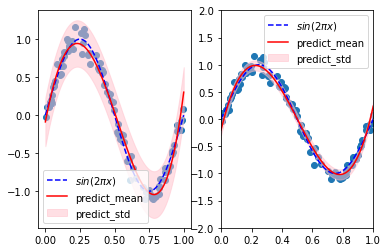

In [15]:
def createData(f,low, high, size):
    x = np.random.uniform(low=low, high=high, size=size)
    t = f(x) + np.random.normal(loc=0, scale=1/11.1, size=size)
    return x,t

def main():

    def func(x):
        return np.sin(2*np.pi*x)

    x_train, t_train = createData(func, 0 , 1, 100)

    # 5次元の多項式を使用する
    poly = Polynomial(5)
    X = poly.getFunction(x_train)

    # 訓練データを用いて、学習を行う
    model = PredictedDist(mode=BAYES)
    model1 = PredictedDist(mode=MLE)
    model.fit(X,t_train)
    model1.fit(X, t_train)

    x = np.linspace(0,1,100)
    y, y_std = model.predict(poly.getFunction(x))
    y1, y1_std = model1.predict(poly.getFunction(x))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.scatter(x_train, t_train)
    ax1.plot(x, func(x), color='blue',  linestyle = "dashed",label="$sin(2\pi x)$")
    ax1.plot(x, y, color='red', label="predict_mean")
    ax1.fill_between(x, y-y_std, y+y_std, color='pink', alpha=0.5, label="predict_std")


    ax1.legend()

    ax2.scatter(x_train, t_train)
    ax2.plot(x, func(x), color='blue', linestyle = "dashed", label="$sin(2\pi x)$")
    ax2.plot(x, y1, color='red', label="predict_mean")
    ax2.fill_between(x, y1-y1_std, y1+y1_std, color='pink', alpha=0.5, label="predict_std")
    ax2.set_xlim(0,1)
    ax2.set_ylim(-2.0,2.0)
    ax2.legend()

    plt.show()


if __name__ == "__main__":
    main()

## 考察

訓練データが少ない場合において、
ベイズ推定の場合は、事前情報を考慮する事ができる点で、事前情報に沿った分布を算出できている。
一方で、最尤推定法の場合は、明らかに過学習となっている。

**■訓練データが5つの場合における、予測分布**
![ガウス分布](C:/work/数学/Prml上/PRML/PRML/1/予測分布（訓練データ数5個）.png) 

ここで、最尤推定法、ベイズ推定法の両方において、精度の式に着目すると、
データ数が増えれば増えるほど、精度は改善していくのがわかる。
訓練データを100個用意した時の予測分布は以下の図となる。
どちらの推定法も背景の生成モデルに近づく事がわかる。

![ガウス分布](C:/work/数学/Prml上/PRML/PRML/1/予測分布（訓練データ100個）.png) 

